# Simon's Algorithm

<hr>

**Problem:**

We are given a function $ f : {\{0, 1\}}^n \rightarrow \{0, 1\}^n $ as a black box. We only know that $ f(x) = f(x\oplus s) $ for sone hidden binary string $s$.

Classically, because of the birthday paradox, we can find out the $s$ string in no better than $2^{n/2}$ queries. Question is, can we do better with a qauntum computer? Answer is yes, implementing the Simon's algorithm which solves the problem in polinomial time instead of classical exponential time. It works in four steps:

1. Set up the superposition: $ \frac{1}{\sqrt{2}} |x> + \frac{1}{\sqrt{2}} |x\oplus s> \tag{1}$ 
2. Apply Fourier sampling to get a random $y$ such that: $y\cdot s \equiv 0 \space (mod \space 2) \tag{2}$
3. Repeat the above process $n-1$ times to get $n-1$ linearly indipendent equations: $ y^{(1)}_{1}s_{1} + \cdot \cdot \cdot + y^{(1)}_{n}s_{n} \equiv 0 \space (mod \space 2) \\ \vdots \\ y^{(n-1)}_{1}s_{1} + \cdot \cdot \cdot + y^{(n-1)}_{n}s_{n} \equiv 0 \space (mod \space 2) \tag{3}$
4. Solve for $s$.

<hr>

### 1. Set up the initial superposition

First of all we need to set up the superposition given by (1). We do it starting with two registers of $n$ qubits, one that will represent $|x>$ and the other $|f(x)>$, both starting in state $|0^{n}>$. 
$\\$ In this example we will use $n=3$ and $s=101$.

In [1]:
n = 3
s = '101'

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, Aer, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
import matplotlib as mpl
from qiskit.tools.monitor import job_monitor
from qiskit_textbook.tools import simon_oracle

In [3]:
circuit = QuantumCircuit(n*2, n)

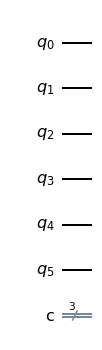

In [4]:
circuit.draw(output='mpl')

The superposition (1) is now created applying the H gate to the first register, then computing $f(x)$ on the second and then measuring it. The logic behind the resulting can be seen with the following example table:

| $x$ | $f(x)$| 
| :-: | :-: |
| $000$ | $000$ |
| $011$ | $100$ |
| $100$ | $010$ |
| $101$ | $000$ |
| $110$ | $100$ |
| $111$ | $001$ |
|$\dots$|$\dots$|

You can see that if we measure e.g. $f(x) = 100$ we know that there are only two possibilities for $x \space (\space 011 $ and $ 110 \space )$, so that the resulting state in the first register will be the equal superposition of these two states.

<br> We can also avoid measuring the second register following the deffered measurement principle.

In [5]:
circuit.h(range(n))
circuit.barrier()

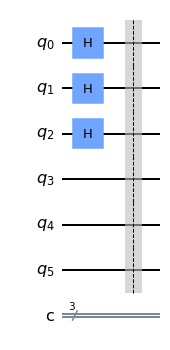

In [6]:
circuit.draw(output='mpl')

In [ ]:
circuit += simon_oracle(s)

circuit.barrier()

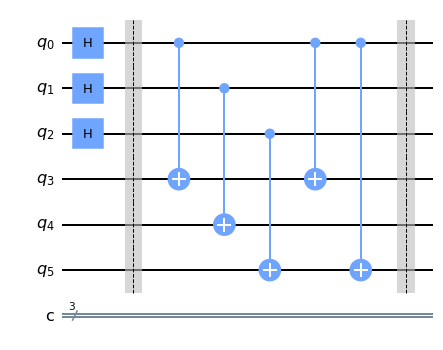

In [8]:
circuit.draw(output='mpl')

### 2. Fourier sampling

Now we can apply the H gate again to the first register and the state we get is 
$\sum_{y} \beta_{y} |y>$
, where: 

$$\beta_{y} = \frac{1}{\sqrt{2}} \left(\frac{(-1)^{x\cdot y}}{2^{n/2}} + \frac{(-1)^{(x\oplus s)\cdot y}}{2^{n/2}} \right) = \frac{(-1)^{x\cdot y}}{2^{(n+1)/2}} \left( 1 + (-1)^{y\cdot s} \right)  $$ 


(the first $\frac{1}{\sqrt{2}} $ coming from the normalization of the incoming state). For these amplitudes there are two cases:

**Case 1:**<br>
$y\cdot s \equiv 1 \space (mod \space 2)$ so that $\beta_{y} = 0$ and we can't measure this state.

**Case 2:**<br>
$y\cdot s \equiv 0 \space (mod \space 2)$ so that $\beta_{y} = \frac{-1}{2^{(n-1)/2}}$ and we measure the state with probability $|\beta_{y}|^{2} = \frac{1}{2^{n-1}}$.

In [9]:
circuit.h(range(n))
circuit.barrier()

In [10]:
circuit.measure(range(n), range(n))

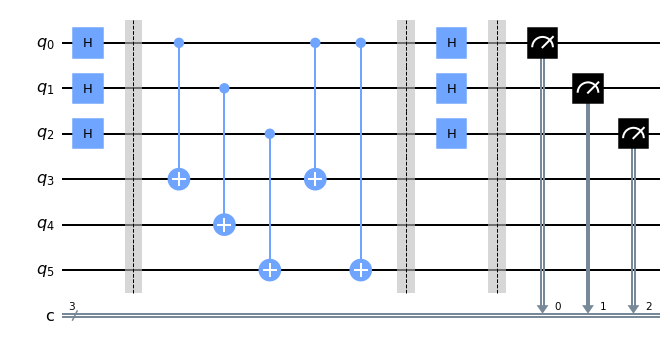

In [11]:
circuit.draw(output='mpl')

### 3. Repeat n-1 times

Now we can sample $n-1$ times this process and hopefully get $n-1$ linearly independent equations. In practice is better to simulate more times due to probabilistic outcomes from the QPU. We also ignore the $000$ answer for both $y$ and $s$.

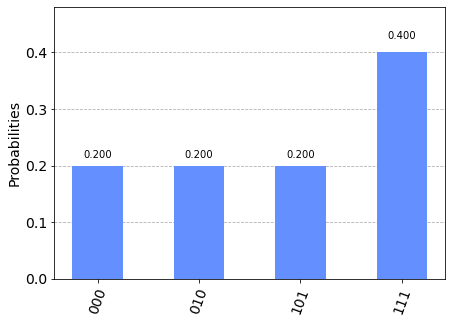

In [12]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(circuit, shots=10)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

From here we can reconstruct $s$, in fact the system of solutions $\neq 000$ is linearly independent in the $Z_{2}$ ring. Unfortunately no python package has a solver for modular system like these, but the algorithm can be implemented easily, in fact it follows that:

$$ s_3 = 0$$
$$ s_1 + s_2 = 0$$

but since we are in the congruece class modulo 2, $s_1$ has to be equal to $s_2$, and since we are avoiding the trivial solution we have $s_1 = s_2 = 1$ and $ s = 101$.